# Improving the machine learning model

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

First predictions = baseline predictions. First model = baseline model.

From a data perspective:
* Could we collect more data? (generally, the more data, the better)
* Could we improve our data?

From a model perspective:
* Is there a better model we could use?
* Could we improve the current model?

Hyperparameters vs. Parameters
* Parameters = model find these patterns in data
* Hyperparameters = settings on a model you can adjust to (potentially) improve its ability to find patterns

> **Note**: Patterns in data are also often referred to as data parameters. The difference between parameters and hyperparameters is that a machine learning model seeks to find parameters in data on its own, whereas hyperparameters are settings on a model on which person can adjust.

Since we have two existing datasets, we'll look at improving our results from a model perspective.

More specifically, we'll look at how we could improve our RandomForestClassifier and RandomForestRegressor models through hyperparameter tuning.

What even are hyperparameters?

Let's check them out bur first, we'll instantiate a RandomForestClassifier.

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)

When we instantiate a model like above, we're using the default hyperparameters.

These get printed out when you call the model instance and get_params().

In [17]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

You'll see things like `max_depth`, `min_samples_split`, and `n_estimators`.

Each of these is a `hyperparameter` of the `RandomForestClassifier` you can adjust.

You can think of hyperparameters as being similar to dials on an oven.

On the default setting, your oven might do an okay job cooking your favourite meal. But with a little experimentation, you find it does better when you adjust the settings.

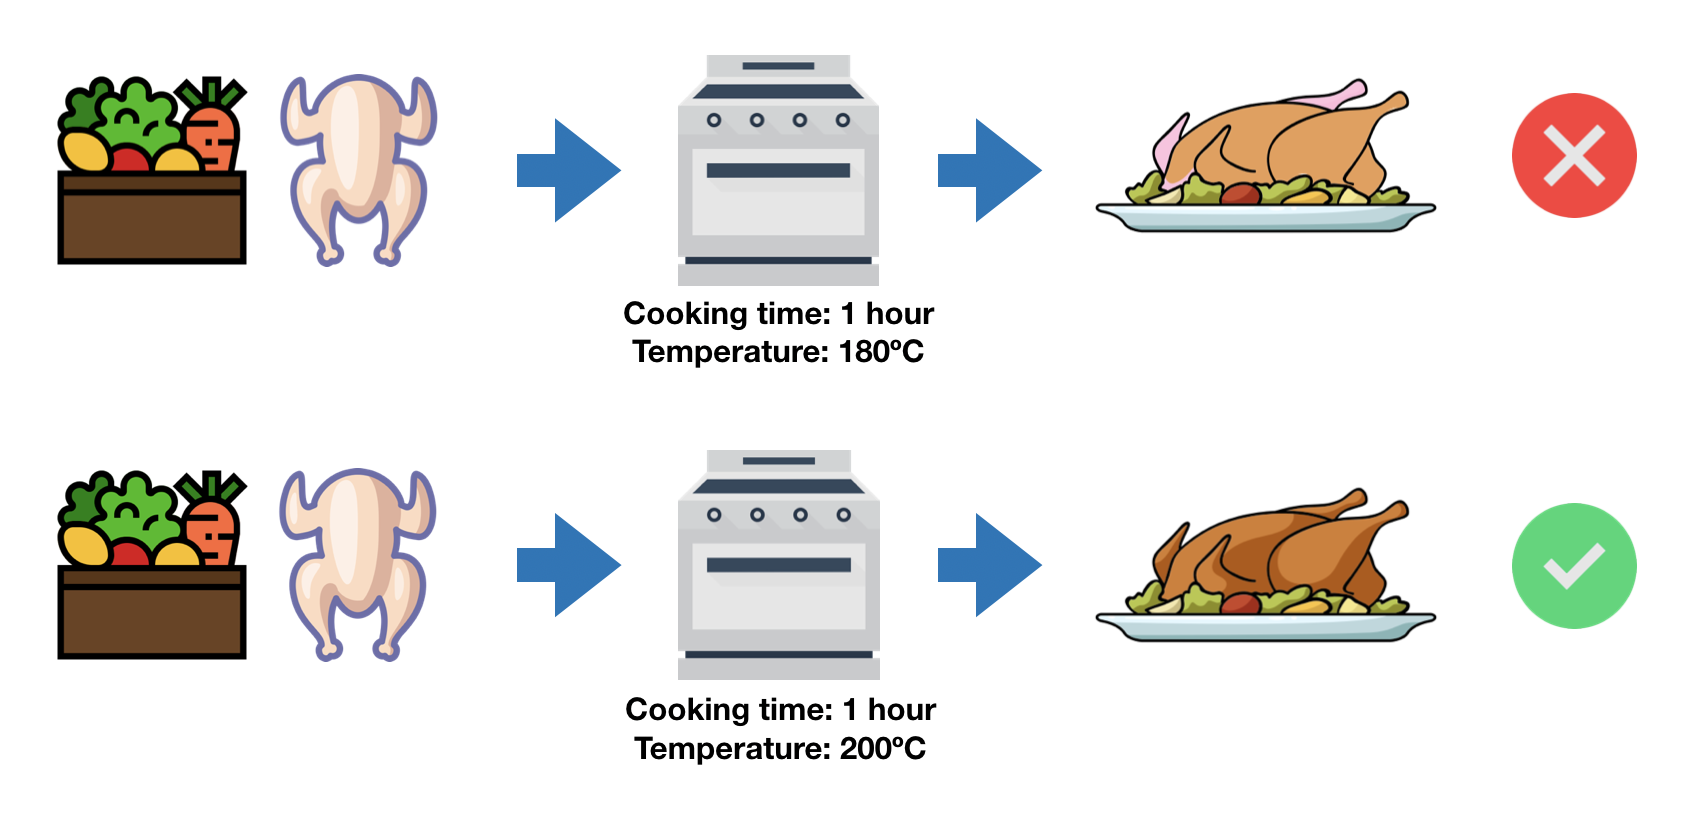

The same goes for improving a machine learning model by hyperparameter tuning.

The default hyperparameters on a machine learning model may find patterns in data well. But there's a chance that adjusting the hyperparameters may improve a model's performance.

Every machine learning model will have different hyperparameters you can tune.

You might be thinking, "How the hell do I remember all of these?"

It's why we're focused on the Random Forest.

Instead of memorizing all of the hyperparameters for every model, we'll see how it's done with one.

And then knowing these principles, you can apply them to a different model if needed.

Reading the [Scikit-Learn documentation for the Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), you'll find they suggest trying to `change n_estimators` (the number of trees in the forest) and `min_samples_split` (the minimum number of samples required to split an internal node).

We'll try tuning these as well:
* `max_features` (the number of features to consider when looking for the best split)
* `max_depth` (the maximum depth of the tree)
* `min_samples_leaf` (the minimum number of samples required to be at a leaf node)

If this still sounds like a lot, the good news is that the process we're taking with the Random Forest and tuning its hyperparameters can be used for other machine learning models in Scikit-Learn. The only difference is that with a different model, the hyperparameters you tune will be different.

Adjusting hyperparameters is usually an experimental process to figure out which are best. As there's no real way of knowing which hyperparameters will be best when starting out.

To get familar with hyparameter tuning, we'll take our RandomForestClassifier and adjust its hyperparameters in 3 ways.
1. By hand
2. Randomly with `sklearn.model_selection.RandomizedSearchCV`
3. Exhaustively with `sklearn.model_selection.GridSearchCV`

# 1. Tuning hyperparameters by hand

So far we've worked with training and test datasets.

You train a model on a training set and evaluate it on a test dataset.

But hyperparameter tuning introduces a thrid set, a validation set.

Now the process becomes:
1. Train a model on the training data.
2. (Try to) improve the model's hyperparameters on the validation set.
3. Evaluate the model on the test set.

If our starting dataset contained 100 different patient records labels indicating who had heart disease and who didn't and we wanted to build a machine learning model to predict who had heart disease and who didn't, it might look like this:

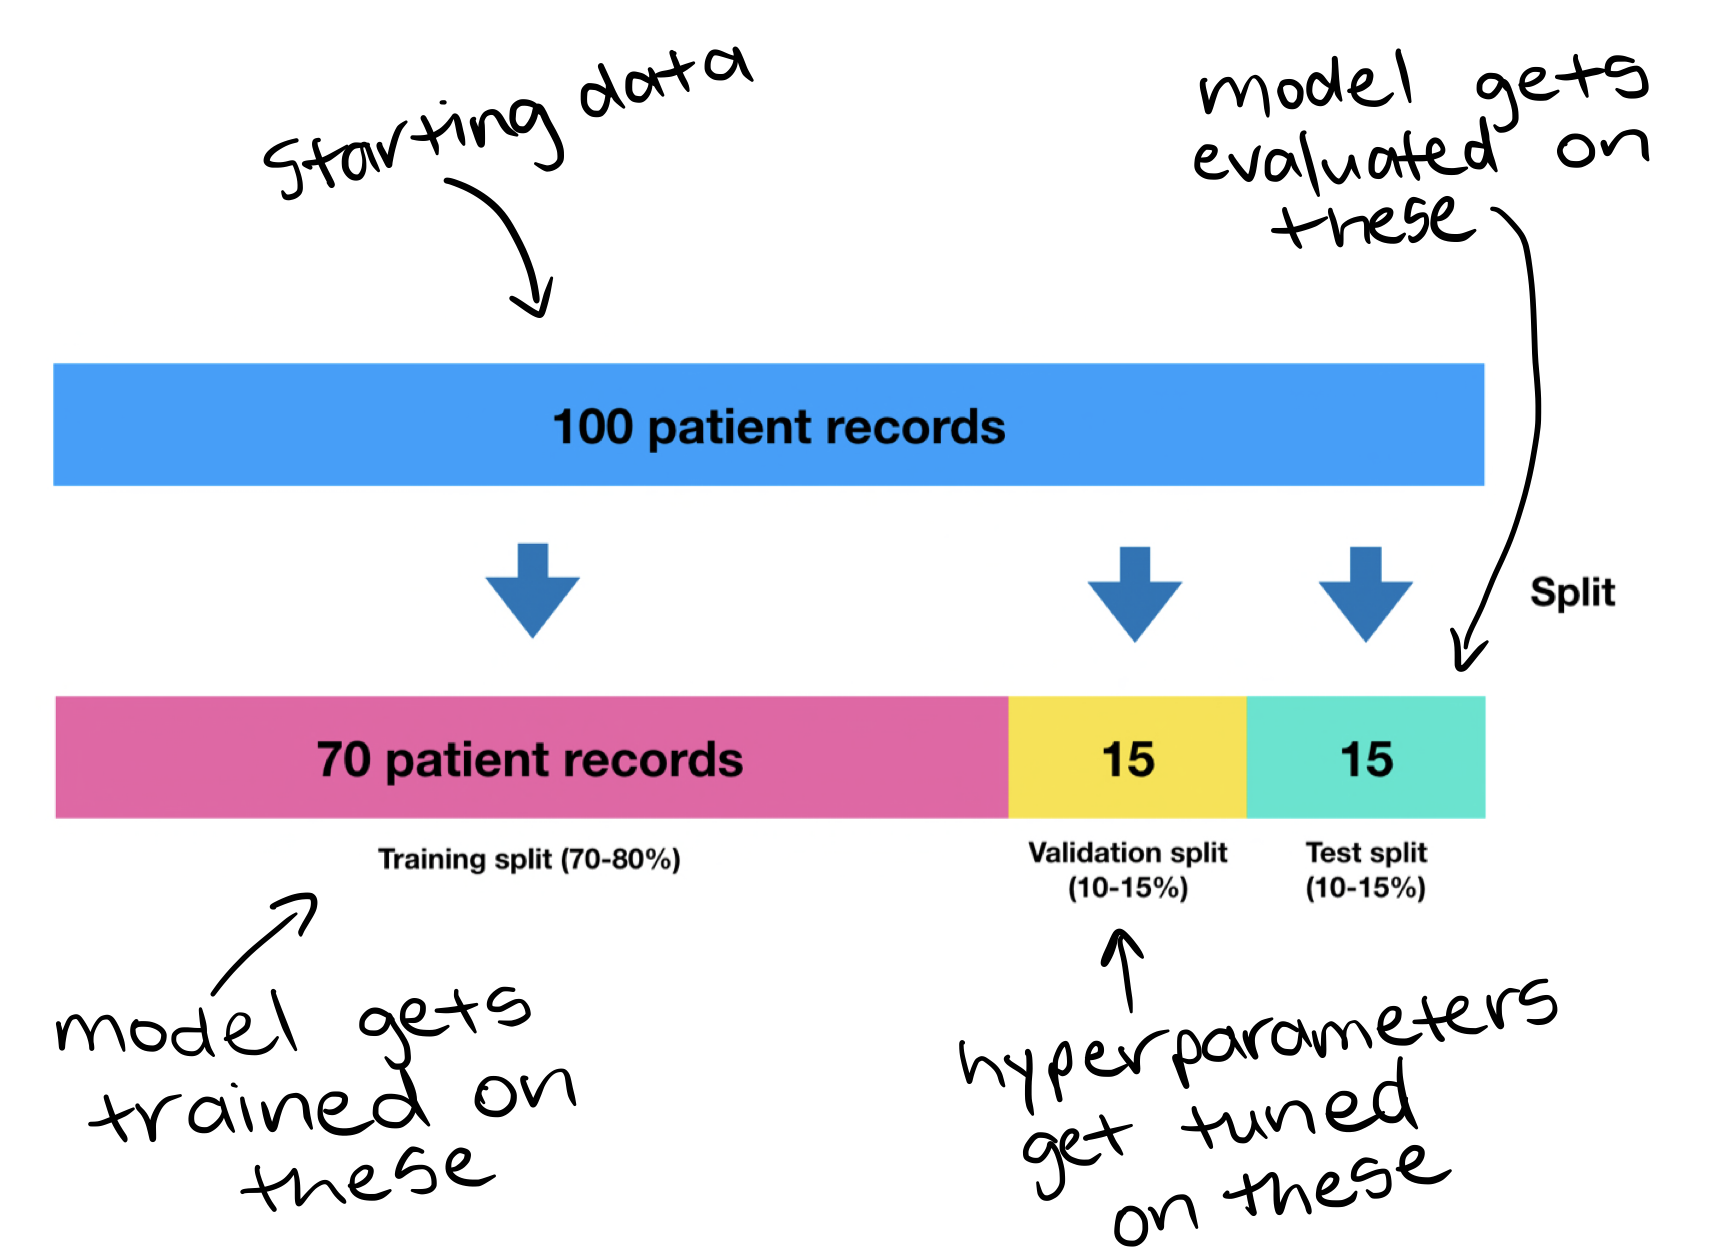

Since we know we're using a `RandomForestClassifier` and we know the hyperparameters we want to adjust, let's see what it looks like.

First, let's remind ourselves of the base parameters.

In [24]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

And we're going to adjust:
* max_depth
* max_features
* min_samples_leaf
* min_samples_split
* n_estimators

We'll use the same code as before, except this time we'll create a training, validation, and test split.

The training set containing 70% of the data, and the validation and test sets each containing 15%.

Let's get some baseline results, then we'll tune the model.

And since we're going to be evaluating a few models, let's make an evaluation function.

In [27]:
def evaluate_preds(y_true: np.array, 
                   y_preds: np.array) -> dict:
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.

    Returns several metrics in the form of a dictionary.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

Now let's recreate a previous workflow, except we'll add in the creation of a validation set.

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Set the seed
np.random.seed(42)

# Read in the data
heart_disease = pd.read_csv("./resources/heart-disease.csv") # load in from local directory
# heart_disease = pd.read_csv("https://raw.githubusercontent.com/mrdbourke/zero-to-mastery-ml/master/data/heart-disease.csv") # load directly from URL (source: https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/data/heart-disease.csv)

# Split into X (features) & y (labels)
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Training and test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create validation and test split by spliting testing data in half (30% test -> 15% validation, 15% test)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_valid)

# Evaluate the classifier
baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Acc: 80.00%
Precision: 0.78
Recall: 0.88
F1 score: 0.82


{'accuracy': 0.8, 'precision': 0.78, 'recall': 0.88, 'f1': 0.82}

In [36]:
# Check the sizes of the splits
print(f"Training data: {len(X_train)} samples, {len(y_train)} labels")
print(f"Validation data: {len(X_valid)} samples, {len(y_valid)} labels")
print(f"Testing data: {len(X_test)} samples, {len(y_test)} labels")

Training data: 212 samples, 212 labels
Validation data: 45 samples, 45 labels
Testing data: 46 samples, 46 labels


Now we'll change 1 of the hyperparameters, `n_estimators=100` (default) to `n_estimators=200` and see if it improves on the validation set.|

In [40]:
np.random.seed(42)

# Create a second classifier
clf_2 = RandomForestClassifier(n_estimators=200)
clf_2.fit(X_train, y_train)

# Make predictions
y_preds_2 = clf_2.predict(X_valid)

# Evaluate the 2nd classifier
clf_2_metrics = evaluate_preds(y_valid, y_preds_2)

Acc: 77.78%
Precision: 0.77
Recall: 0.83
F1 score: 0.80


It looks like doubling the n_estimators value performs worse than the default, perhaps there's a better value for n_estimators?

And what other hyperparameters could we change?

Wait...This could take a while if all we're doing is building new models with new hyperparameters each time.

Surely there's a better way? There is.

# 2. Hyperparameter tuning with `RandomizedSearchCV`

Scikit-Learn's `sklearn.model_selection.RandomizedSearchCV` allows us to randomly search across different hyperparameters to see which work best.

It also stores details about the ones which work best!

Let's see it in action.

First, we create a dictionary of parameter distributions (collections of different values for specific hyperparamters) we'd like to search over.

This dictionary comes in the form:

param_distributions = {"hyperparameter_name": [values_to_randomly_try]}

Where `"hyperparameter_name"` is the value of a specific hyperparameter for a model and `[values_to_randomly_try]` is a list of values for that specific hyperparamter to randomly try.

In [47]:
# Hyperparameter grid RandomizedSearchCV will search over
param_distributions = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
                       "max_depth": [None, 5, 10, 20, 30],
                       "max_features": ["sqrt", "log2", None],
                       "min_samples_split": [2, 4, 6, 8],
                       "min_samples_leaf": [1, 2, 4, 8]}

Where did these values come from?

They're made up.

Made up?

Yes.

Not completely pulled out of the air, but after reading the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on Random Forest's you'll see some of these values have certain values which usually perform well, and certain hyperparameters take strings rather than integers.

Now we've got the parameter distribution dictionary setup, Scikit-Learn's `RandomizedSearchCV` will look at it, pick a random value from each, instantiate a model with those value,s and test each model.

How many models will it test?

As many as there are for each combination of hyperparameters to be tested. Let's add them up.

In [50]:
# Count the total number of hyperparameter combinations to test
total_randomized_hyperparameter_combintions_to_test = np.prod([len(value) for value in param_distributions.values()])
print(f"There are {total_randomized_hyperparameter_combintions_to_test} potential combinations of hyperparameters to test.")

There are 1440 potential combinations of hyperparameters to test.


That's a lot of combinations!

Or...

We can set the `n_iter` parameter to limit the number of models `RandomizedSearchCV` tests (e.g., `n_iter=20` means to try `20` different random combinations of hyperparameters and will cross-validate each set, so if `cv=5`, 5x20 = 100 total fits).

The best thing?

The results we get will be cross-validated (hence the CV in `RandomizedSearchCV`), so we can use `train_test_split()`.

And since we're going over so many different models, we'll set `n_jobs=-1` in our `RandomForestClassifier` so Scikit-Learn takes advantage of all the cores (processors) on our computers.

Let's see it in action.

> **Note**: Depending on `n_iter` (how many models you test), the different values in the hyperparameter grid, and the power of your computer, running the cell below may take a while (for reference, it took about ~1.5 minutes on my MacBook Pro).

In [53]:
# Start the timer
import time
start_time = time.time()

from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all available cores on your machine (if this causes errors, try n_jobs=1)
clf = RandomForestClassifier(n_jobs=-1)

# Setup RandomizedSearchCV 
n_iter = 30 # try 30 models total
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=param_distributions,
                            n_iter=n_iter, 
                            cv=5, # 5-fold cross-validation
                            verbose=2) # print out results

# Fit the RandomizedSearchCV version of clf (does cross-validation for us, so no need to use a validation set)
rs_clf.fit(X_train, y_train);

# Finish the timer
end_time = time.time()
print(f"[INFO] Total time taken for {n_iter} random combinations of hyperparameters: {end_time - start_time:.2f} seconds.")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END max_depth=10, max_features=None, min_samples_leaf=8, min_samples_split=2, n_estimators=50

When RandomizedSearchCV goes through n_iter combinations of of hyperparameter search space, it stores the best ones in the attribute best_params_.

In [58]:
# Find the best hyperparameters found by RandomizedSearchCV
rs_clf.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 30}

Now when we call `predict()` on `rs_clf` (our `RandomizedSearchCV` version of our classifier), it'll use the best hyperparameters it found.

In [62]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 85.25%
Precision: 0.85
Recall: 0.88
F1 score: 0.86


Thanks to RandomizedSearchCV testing out a bunch of different hyperparameters, we get a nice boost to all of the evaluation metrics for our classification model.

# 3. Hyperparameter tuning with `GridSearchCV`

There's one more way we could try to improve our model's hyperparamters.

And it's with `sklearn.model_selection.GridSearchCV`.

The main difference between `GridSearchCV` and `RandomizedSearchCV` is `GridSearchCV` searches across a grid of hyperparamters exhaustively (it will try every combination possible), where as, `RandomizedSearchCV` searches across a grid of hyperparameters randomly (stopping after `n_iter` combinations).

`GridSearchCV` also refers to a dictionary of parameter distributions as a parameter grid (via the parameter `param_grid`).

For example, let's see our dictionary of hyperparameters.

In [67]:
param_distributions

{'n_estimators': [10, 100, 200, 500, 1000, 1200],
 'max_depth': [None, 5, 10, 20, 30],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_split': [2, 4, 6, 8],
 'min_samples_leaf': [1, 2, 4, 8]}

`RandomizedSearchCV` tries n_iter combinations of different values.

Whereas `GridSearchCV` will try every single possible combination.

And if you remember from before, when we did the calculation: `max_depth` has 4 values, `max_features` has 2, `min_samples_leaf` has 3, `min_samples_split` has 3, `n_estimators` has 5.

That's 4x2x3x3x5 = 360 models!

This could take a long time depending on the power of the computer you're using, the amount of data you have, and the complexity of the hyperparameters (usually higher values mean a more complex model).

In our case, the data we're using is relatively small (only ~300 samples).

Since we've already tried to find some ideal hyperparameters using `RandomizedSearchCV`, we'll create another hyperparameter grid based on the `best_params_` of `rs_clf` with fewer options and then try to use `GridSearchCV` to find a more ideal set.

In essence, the workflow could be:

1. Tune hyperparameters by hand to get a feel of the data/model.
2. Create a large set of hyperparameter distributions and search across them randomly with `RandomizedSearchCV`.
3. Find the best hyperparameters from 2 and reduce the search space before searching across a smaller subset exhaustively with `GridSearchCV`.
   
> **Note**: Based on the `best_params_` of `rs_clf` implies the next set of hyperparameters we'll try are roughly in the same range as the best set found by `RandomizedSearchCV`.

In [70]:
# Create hyperparameter grid similar to rs_clf.best_params_
param_grid = {"n_estimators": [200, 1000],
              "max_depth": [30, 40, 50],
              "max_features": ["log2"],
              "min_samples_split": [2, 4, 6, 8],
              "min_samples_leaf": [4]}

We've created another grid of hyperparameters to search over, this time with less total.

In [75]:
# Count the total number of hyperparameter combinations to test
total_grid_search_hyperparameter_combinations_to_test = np.prod([len(value) for value in param_grid.values()])
print(f"There are {total_grid_search_hyperparameter_combinations_to_test} combinations of hyperparameters to test.")
print(f"This is {total_randomized_hyperparameter_combintions_to_test/total_grid_search_hyperparameter_combinations_to_test} times less\
 than before (previous: {total_randomized_hyperparameter_combintions_to_test}).")

There are 24 combinations of hyperparameters to test.
This is 60.0 times less than before (previous: 1440).


Now when we run `GridSearchCV`, passing it our classifier (clf), parameter grid (`param_grid`) and the number of cross-validation folds we'd like to use (cv=5), it'll create a model with every single combination of hyperparameters, and then cross-validate each 5 times (for example, 36 hyperparameter combinations * 5 = 135 fits in total) and check the results.

> **Note**: Depending on the compute power of the machine you're using, the following cell may take a few minutes to run (for reference, it took ~60 seconds on my MacBook Pro).

In [78]:
# Start the timer
import time
start_time = time.time()

from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all available machine cores (if this produces errors, try n_jobs=1)
clf = RandomForestClassifier(n_jobs=-1)

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=param_grid,
                      cv=5, # 5-fold cross-validation
                      verbose=2) # print out progress

# Fit the RandomizedSearchCV version of clf
gs_clf.fit(X_train, y_train);

# Find the running time
end_time = time.time()

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.9s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.9s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=

In [79]:
# How long did it take? 
total_time = end_time - start_time
print(f"[INFO] The total running time for running GridSearchCV was {total_time:.2f} seconds.")

[INFO] The total running time for running GridSearchCV was 140.24 seconds.


Once it completes, we can check the best hyperparameter combinations it found using the best_params_ attribute.|

In [83]:
# Check the best hyperparameters found with GridSearchCV
gs_clf.best_params_

{'max_depth': 30,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

And by default when we call the predict() function on gs_clf, it'll use the best hyperparameters.

In [88]:
# Max predictions with the GridSearchCV classifier
gs_y_preds = gs_clf.predict(X_test)

# Evaluate the predictions
gs_metrics = evaluate_preds(y_test, gs_y_preds)
gs_metrics

Acc: 88.52%
Precision: 0.88
Recall: 0.91
F1 score: 0.89


{'accuracy': 0.89, 'precision': 0.88, 'recall': 0.91, 'f1': 0.89}

Let's create a DataFrame to compare the different metrics.

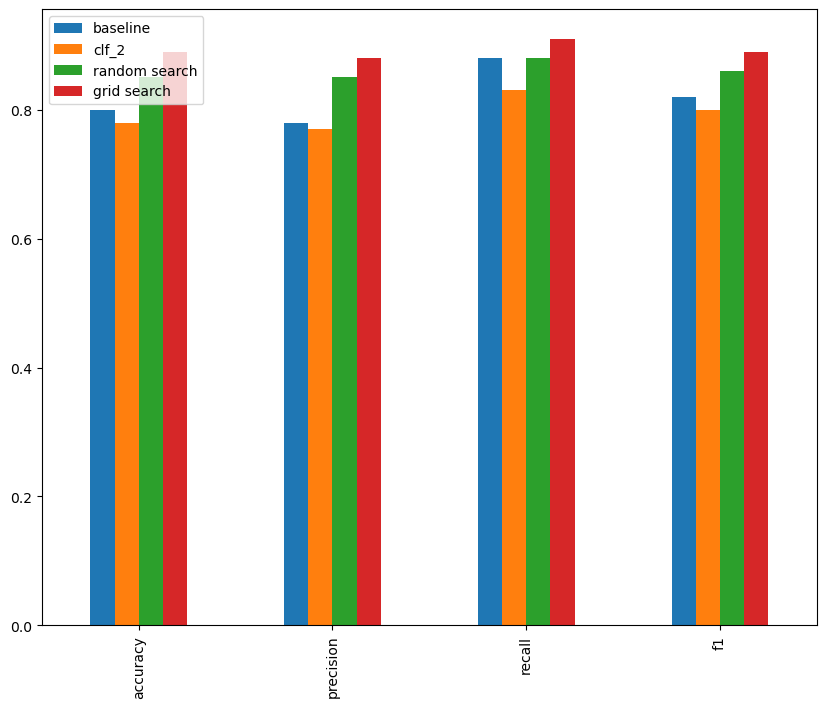

In [106]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "clf_2": clf_2_metrics,
                                "random search": rs_metrics,
                                "grid search": gs_metrics})
compare_metrics.plot.bar(figsize=(10, 8));
plt.show()

After trying many different combinations of hyperparamters, we get a slight improvement in results.

However, sometimes you'll notice that your results don't change much.

These things might happen.

But it's important to remember, it's not over. There more things you can try.

In a hyperparameter tuning sense, there may be a better set we could find through more extensive searching with `RandomizedSearchCV` and `GridSearchCV`, this would require more experimentation.

Other techniques you could:

* **Collecting more data** - Based on the results our models are getting now, it seems like they're very capable of finding patterns. Collecting more data may improve a models ability to find patterns. However, your ability to do this will largely depend on the project you're working on.
* **Try a more advanced model** - Although our tuned Random Forest model is doing pretty well, a more advanced ensemble method such as [XGBoost](https://xgboost.ai/) or [CatBoost](https://catboost.ai/) might perform better. I'll leave these for extra-curriculum.

Since machine learning is part engineering, part science, these kind of experiments are common place in any machine learning project.

Now we've got a tuned Random Forest model, let's find out how we might save it and export it so we can share it with others or potentially use it in an external application.